## ESAT Uncertainty Perturbation Workflow

This notebook implements an uncertainty perturbation workflow for model evaluation.


#### Code Imports

In [1]:
import time
import copy

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm.notebook import trange, tqdm, tnrange
from plotly.subplots import make_subplots
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.error.bootstrap import Bootstrap
from esat_eval.simulator import Simulator
from esat_eval.factor_comparison import FactorCompare
from esat_eval.factor_catalog import FactorCatalog
from esat_eval.perturbation import Perturbation

pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Synethic dataset parameter value ranges
syn_factors_min = 3
syn_factors_max = 8

syn_features_min = 15
syn_features_max = 45

syn_samples_min = 200
syn_samples_max = 1000

outliers = True
outliers_p_min = 0.05
outliers_p_max = 0.1
outliers_mag_min = 1.1
outliers_mag_max = 2

noise_mean_min = 0.05
noise_mean_max = 0.15
noise_scale = 0.01

uncertainty_mean_min = 0.05
uncertainty_mean_max = 0.15
uncertainty_scale = 0.01

contr_curve_min_range = [0.0, 1.0]
contr_curve_max_range = [2.0, 5.0]
contr_curve_scale_range = [0.1, 0.5]

random_seed = 337
k_coef = 0.75

In [3]:
rng = np.random.default_rng(seed=random_seed)

In [4]:
# Initialize the simulator with the above parameters
def generate_synthetic_data(true_factor):
    n_features = rng.integers(low=syn_features_min, high=syn_features_max, size=1)[0]
    n_samples = rng.integers(low=syn_samples_min, high=syn_samples_max, size=1)[0]
    i_outlier_p = round(rng.uniform(low=outliers_p_min, high=outliers_p_max, size=1)[0], 2)
    i_outlier_mag = round(rng.uniform(low=outliers_mag_min, high=outliers_mag_max, size=1)[0], 2)
    contribution_max = round(rng.uniform(low=1.0, high=10.0, size=1)[0], 2)
    print(f"True Factors: {true_factor}, Features: {n_features}, Samples: {n_samples}, Outliers %: {i_outlier_p}, Outliers Magnitude: {i_outlier_mag}, Contribution Max: {contribution_max}")
    simulator = Simulator(seed=rng.integers(low=0, high=10, size=1)[0],
                          factors_n=true_factor,
                          features_n=n_features,
                          samples_n=n_samples,
                          outliers=outliers,
                          outlier_p=i_outlier_p,
                          outlier_mag=i_outlier_mag,
                          contribution_max=contribution_max,
                          noise_mean_min=noise_mean_min,
                          noise_mean_max=noise_mean_max,
                          noise_scale=noise_scale,
                          uncertainty_mean_min=uncertainty_mean_min,
                          uncertainty_mean_max=uncertainty_mean_max,
                          uncertainty_scale=uncertainty_scale,
                          verbose=False
                         )
    curved_factors_count = rng.integers(low=0, high=true_factor, size=1)[0]
    curved_factor_list = rng.choice(list(range(true_factor)), size=curved_factors_count, replace=False)
    for c_i in curved_factor_list:
        # parameters not used by the curve type are ignored
        i_curve_type = rng.choice(['uniform', 'decreasing', 'increasing', 'logistic', 'periodic'], size=1)[0]
        i_curve_min = rng.uniform(low=contr_curve_min_range[0], high=contr_curve_min_range[1], size=1)[0]
        i_curve_max = rng.uniform(low=contr_curve_max_range[0], high=contr_curve_max_range[1], size=1)[0]
        i_curve_scale = rng.uniform(low=contr_curve_scale_range[0], high=contr_curve_scale_range[1], size=1)[0]
        i_curve_frequency = rng.uniform(low=0.1, high=0.9, size=1)[0]
        
        # To keep all as uniform comment out the line below
        # simulator.update_contribution(factor_i=c_i, curve_type=i_curve_type, scale=i_curve_scale, frequency=i_curve_frequency, minimum=i_curve_min, maximum=i_curve_max)
    
    syn_input_df, syn_uncertainty_df = simulator.get_data()
    data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
    data_handler.metrics
    V, U = data_handler.get_data()
    return V, U

## Single Perturbation Instance

A single instance of the run_perturbation function is called. This will create a single SA instance to use as the base model with n_models being the number of perturbed instances to make (each independent of each other) for that single base model.

In [5]:
%%time
true_k = 6
iV, iU = generate_synthetic_data(true_factor=true_k)

True Factors: 6, Features: 24, Samples: 222, Outliers %: 0.06, Outliers Magnitude: 1.8, Contribution Max: 9.26
CPU times: total: 46.9 ms
Wall time: 77.5 ms


In [6]:
estimate_k = 6
n_models = 50
threshold = 0.1

perturb_p = 1.0
perturb_sigma = 0.25
correlation_method = "raae"

In [7]:
perturb = Perturbation(V=iV, U=iU, factors=estimate_k, compare_method=correlation_method, threshold=threshold, models=n_models, perturb_percent=perturb_p, sigma=perturb_sigma, random_seed=random_seed, in_notebook=True)

In [8]:
%%capture
perturb.run()

In [9]:
perturb.compare(in_notebook=True)

17-Jun-25 13:30:26 - Comparing 50 perturbed models using raae
Calculating correlation between base and model factors:   0%|                                                                                                                            | 0/50 [00:00<?, ?it/s]

Calculating correlation between base and model factors:   0%|          | 0/50 [00:00<?, ?it/s]

17-Jun-25 13:30:26 - Perturbed factor mean values                                                                                                                                                               
17-Jun-25 13:30:26 -       Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6
RAAE    0.0443    0.0294    0.0465    0.0401    0.0929    0.0268
17-Jun-25 13:30:26 - 
Perturbation Multiplier Details
17-Jun-25 13:30:26 - first   0.5605
25th    0.8444
50th    0.9999
75th    1.1830
99th    1.7870
sigma   0.2500
dtype: float64
17-Jun-25 13:30:26 - 
Perturbed H Results
17-Jun-25 13:30:26 -              Base  Mean Perturb   % diff  STD Perturb  Min Perturb  \
Feature 1  0.0847        0.0859   1.3906       0.0072       0.0701   
Feature 2  0.0373        0.0374   0.2788       0.0038       0.0300   
Feature 3  0.8565        0.8578   0.1600       0.0044       0.8477   
Feature 4  0.5068        0.4989  -1.5608       0.0145       0.4660   
Feature 5  0.0233        0.0223  -4.5160       

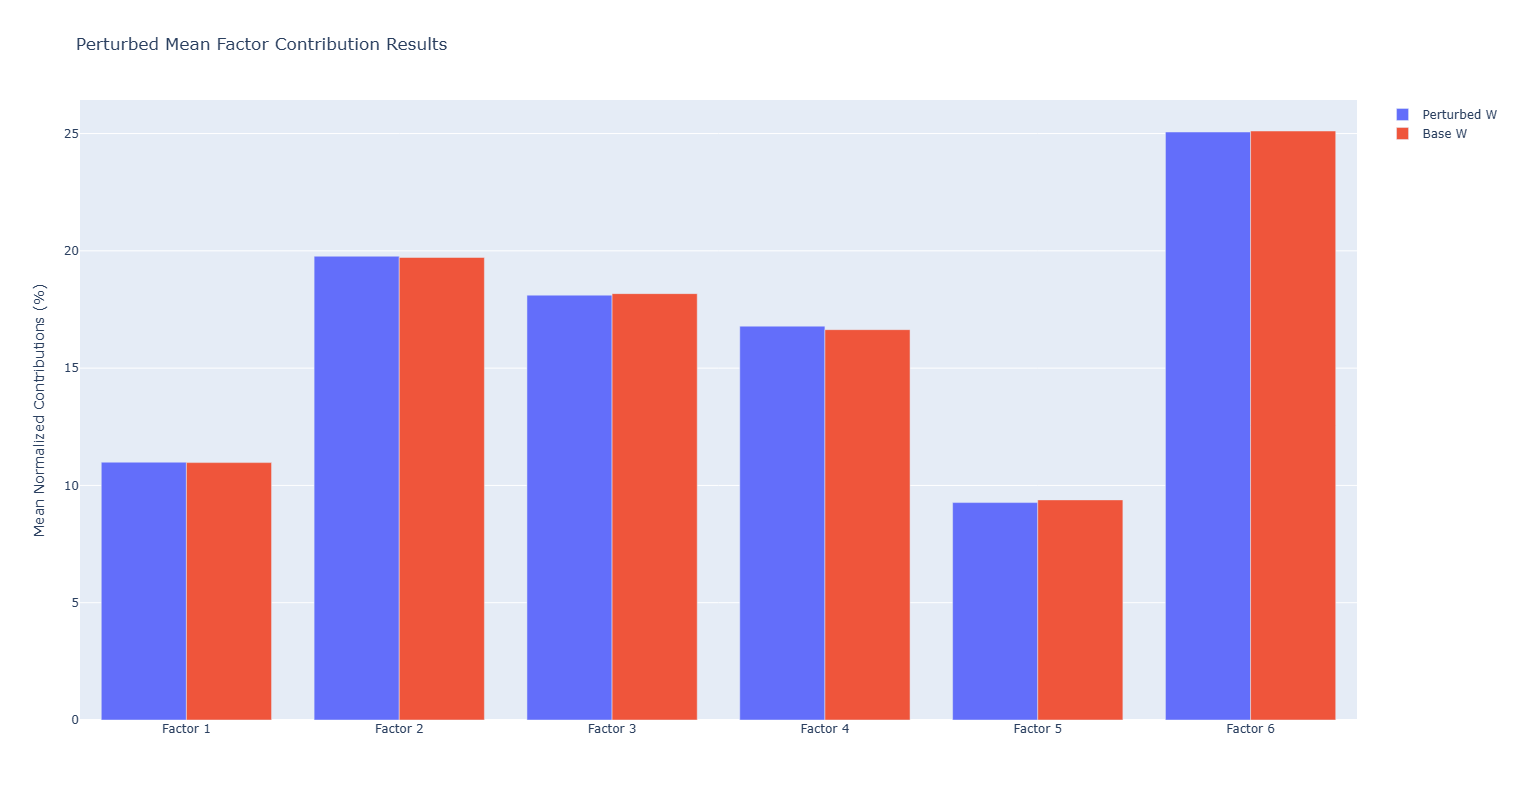

In [10]:
perturb.plot_norm_perturb_contributions()

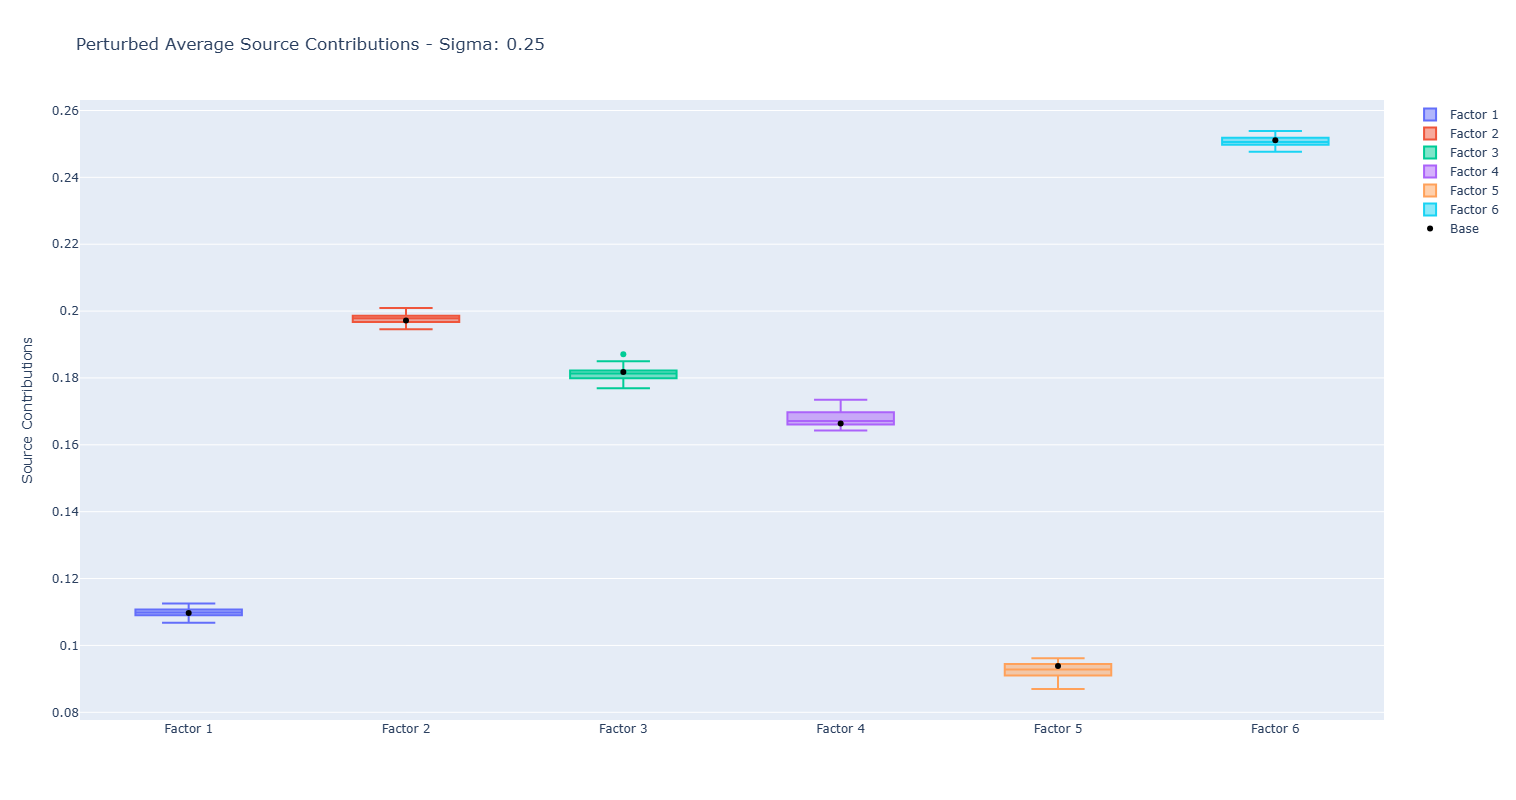

In [11]:
perturb.plot_average_source_contributions()

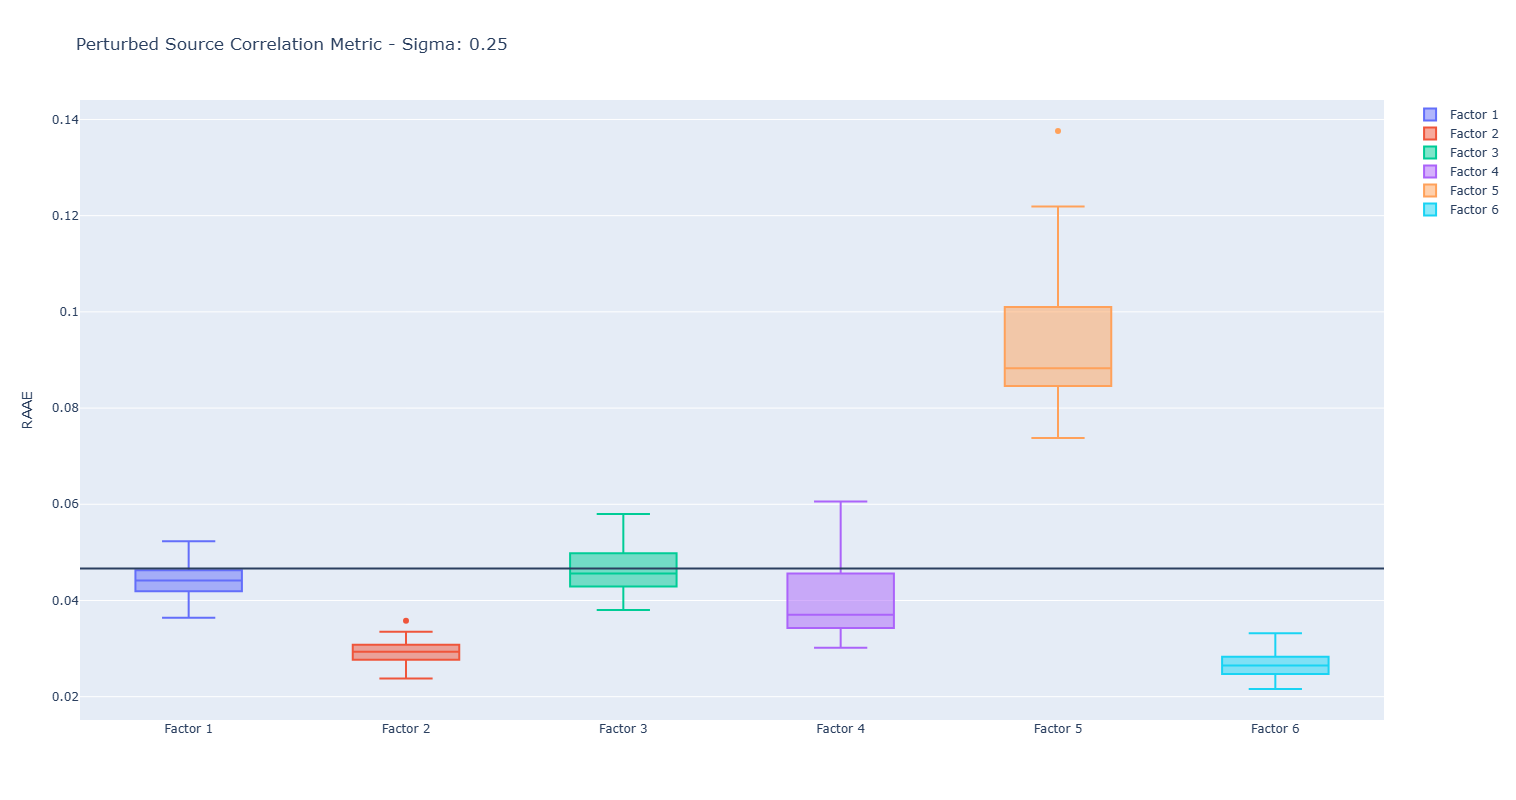

In [12]:
perturb.plot_correlation_metrics()

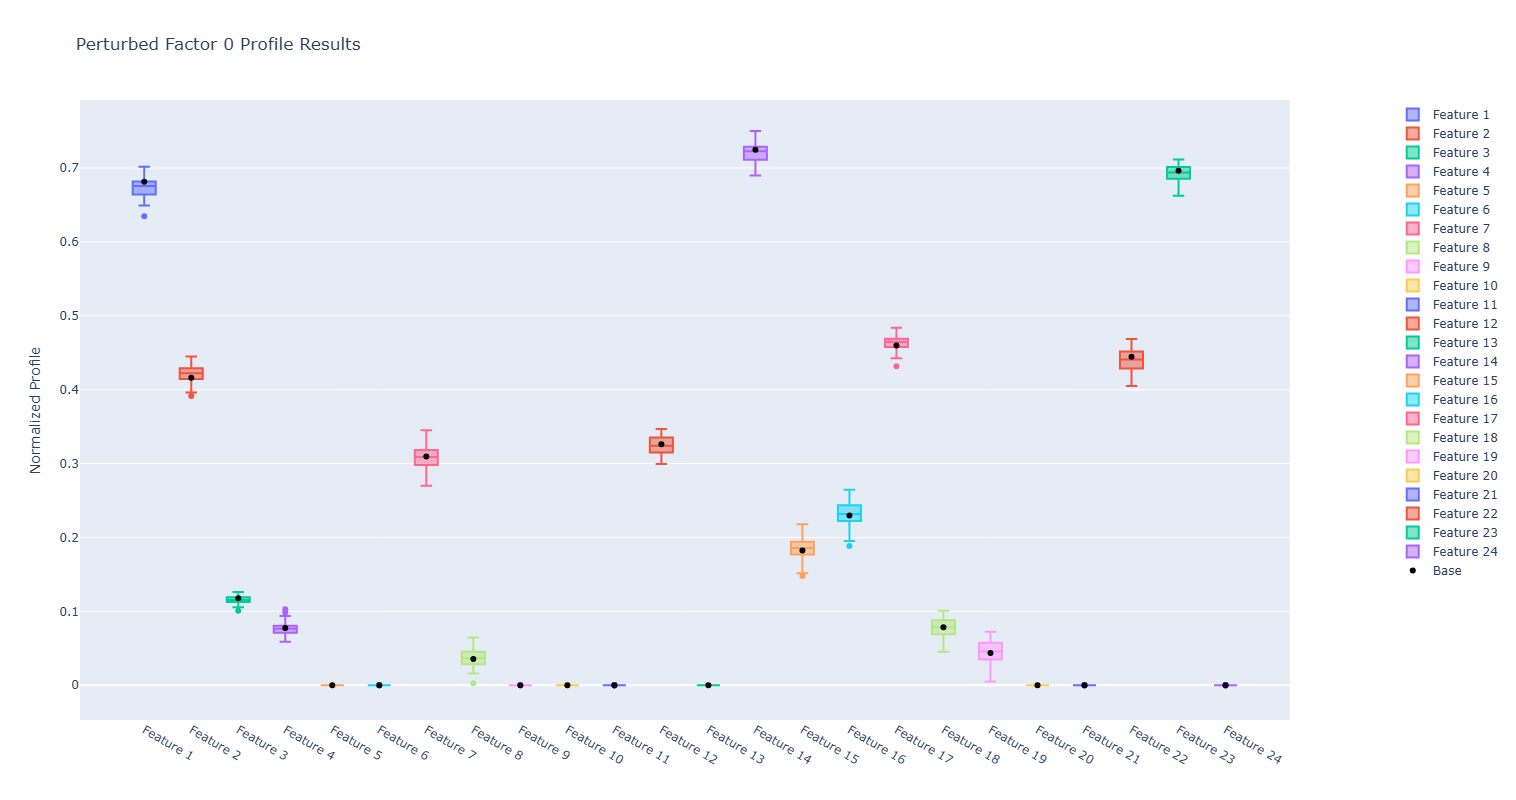

In [13]:
perturb.plot_perturbed_factor(factor_idx=0)